<a href="https://colab.research.google.com/github/osjayaprakash/deeplearning/blob/main/transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
root_dir = kagglehub.dataset_download("shahrukhkhan/im2latex100k")
# path = kagglehub.dataset_download("gregoryeritsyan/im2latex-230k")

print("Path to dataset files:", root_dir)

Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, GRU, Embedding, Bidirectional,
                                     TimeDistributed, Concatenate, RepeatVector, LSTM, MultiHeadAttention, LayerNormalization, Add, Dropout )
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import platform
import sys
import pandas as pd
import sklearn as sk
import scipy as sp
from tensorflow.python.ops.numpy_ops import np_config  
import einops

tf.keras.mixed_precision.set_global_policy('mixed_float16')
np_config.enable_numpy_behavior()
tf.config.experimental.list_physical_devices('GPU')
tf.config.optimizer.set_jit(False)
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
#print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
print(tf.config.list_physical_devices())

2024-11-30 02:47:09.182611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 02:47:10.203545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Python Platform: Linux-5.15.0-1071-aws-x86_64-with-glibc2.29
Tensor Flow Version: 2.13.1

Python 3.8.10 (default, Nov  7 2024, 13:10:47) 
[GCC 9.4.0]
Pandas 2.0.3
Scikit-Learn 1.3.2
SciPy 1.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-11-30 02:47:11.989281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 02:47:12.028055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 02:47:12.028922: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Preprocess

In [5]:
image_size = 256  # We'll resize input images to this size
IMG_SHAPE = (256, 256, 1)
EMBEDDING_DIM = 256
n = 1000

In [6]:
def preprocess_image(image):
    """Preprocess the input image: Resize and normalize."""
    image = tf.image.resize(image, (image_size, image_size))  # Resize to (50, 200)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_and_preprocess_images(image_paths):
    """Load and preprocess a batch of images."""
    # Use Gray scale
    images = [preprocess_image(tf.io.decode_image(tf.io.read_file(path), channels=1))
              for path in image_paths]
    return tf.stack(images)

def prepare_sequences(latex_texts, max_seq_length):
    """Convert LaTeX texts to padded sequences of tokens."""
    sequences = [text_to_sequence(text) for text in latex_texts]
    return pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [7]:
# %%time
# %%prun

df = pd.read_csv(f"{root_dir}/im2latex_train.csv", nrows=n)

train_image_paths = []
train_latex_texts = []

for index, row in df.iterrows():
    train_image_paths += [f"{root_dir}//formula_images_processed/formula_images_processed/{row.image}"]
    train_latex_texts += ["[START] " + row.formula + " [END]"]

train_images = load_and_preprocess_images(train_image_paths)
# Enable Numpy behaviour of TF
# tf.experimental.numpy.experimental_enable_numpy_behavior()

# vocab_size, max_seq_length = fit_tokenizer(train_latex_texts)

# train_sequences = prepare_sequences(train_latex_texts, max_seq_length)
# #train_sequences = np.expand_dims(train_sequences, -1)
# print("train_images:", train_images.shape)
# print("train_sequences:", train_sequences.shape)

2024-11-30 02:47:23.156815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 02:47:23.157683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 02:47:23.158518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size, standardize = None)

In [9]:
tokenizer.adapt(train_latex_texts)

In [10]:
latex_labels = tokenizer(train_latex_texts)
train_sequences = np.asarray(latex_labels)
input_labels = train_sequences[..., :-1]
output_labels = train_sequences[..., 1:]

In [11]:
print(latex_labels.shape)
print(train_images.shape)
vocab_dict = {name: id for id, name in enumerate(tokenizer.get_vocabulary())}
print(vocab_dict)

(1000, 149)
(1000, 256, 256, 1)
{'': 0, '[UNK]': 1, '}': 2, '{': 3, '_': 4, '^': 5, '2': 6, '(': 7, ')': 8, '=': 9, '1': 10, '-': 11, ',': 12, '[START]': 13, '[END]': 14, '+': 15, '\\frac': 16, 'i': 17, '0': 18, 'x': 19, 'a': 20, 'n': 21, '\\,': 22, '.': 23, 'd': 24, '\\mu': 25, 'm': 26, '\\partial': 27, 'e': 28, 'p': 29, 'k': 30, 'c': 31, '\\;': 32, '~': 33, 'j': 34, 'A': 35, 's': 36, '\\alpha': 37, 't': 38, 'r': 39, 'l': 40, '\\right)': 41, '\\left(': 42, '\\nu': 43, '3': 44, 'g': 45, '\\prime': 46, '4': 47, '\\': 48, '|': 49, '\\pi': 50, '\\mathrm': 51, '\\phi': 52, 'b': 53, '\\beta': 54, '[': 55, ']': 56, '\\delta': 57, 'z': 58, 'q': 59, 'D': 60, 'T': 61, '\\cal': 62, 'R': 63, '\\int': 64, '\\gamma': 65, '\\psi': 66, '\\\\': 67, 'N': 68, 'B': 69, 'y': 70, '\\operatorname': 71, '&': 72, 'S': 73, 'f': 74, '\\theta': 75, '\\lambda': 76, '/': 77, '\\bar': 78, 'L': 79, 'M': 80, 'h': 81, '\\hat': 82, 'H': 83, 'E': 84, 'F': 85, '\\tilde': 86, '\\sqrt': 87, '\\sum': 88, 'I': 89, '\\xi': 90

[START] \phi ( \Gamma ) ( m ; p _ { i } ) = \int _ { 0 } ^ { \infty } \frac { F _ { \Gamma } ( r ; m ; p _ { i } ) } { r } d r , [END]
[ 13  52   7 118   8   7  26 113  29   4   3  17   2   8   9  64   4   3
  18   2   5   3 117   2  16   3  85   4   3 118   2   7  39 113  26 113
  29   4   3  17   2   8   2   3  39   2  24  39  12  14   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
[ 52   7 118   8   7  26 113  29   4   3  17   2   8   9  64   4   3  18
   2   5   3 117   2  16   3  85   4   3 118   2   7  39 113  26 113  29
   4   3  17   2   8   2   3  39   2  24  39  12  14   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0

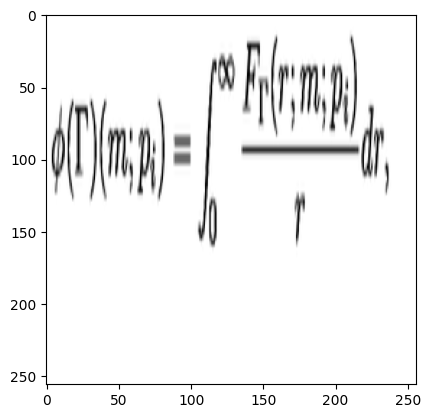

In [12]:
idx = np.random.choice(range(train_images.shape[0]))
image = train_images[idx]
plt.imshow(image.numpy(), cmap="gray")
print(train_latex_texts[idx])
print(input_labels[idx])
print(output_labels[idx])

## Transformer Model

In [13]:


learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = EMBEDDING_DIM
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

lstm_units = 256
max_seq_len_1 = max(len(seq) for seq in latex_labels) - 1
print(num_patches)

1764


In [14]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.raw_ops.Shape(input=images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = tf.image.extract_patches(images=images, sizes=[1,self.patch_size, self.patch_size,1], strides=[1,self.patch_size, self.patch_size,1], padding='VALID', rates=[1, 1, 1, 1])
        new_shape = (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels)
        # print(f"PATCHES: {patches.shape}")
        # print(f"RESHAPE: {new_shape}")
        patches = tf.reshape(
            patches,
            shape=new_shape,
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [15]:
# plt.imshow(image.numpy(), cmap="gray")
# plt.axis("off")
# image = tf.expand_dims(image, axis = 0)

# print(f"Image size: {image.shape}")
# patches = Patches(patch_size)(image)
# print(f"Image size: {image.shape}")
# print(f"Patch size: {patch_size} X {patch_size}")
# print(f"Patches per image: {patches.shape[1]}")
# print(f"Elements per patch: {patches.shape[-1]}")

# n = int(np.sqrt(patches.shape[1]))
# plt.figure(figsize=(4, 4))
# for i, patch in enumerate(patches[0]):
#     ax = plt.subplot(n, n, i + 1)
#     patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
#     plt.imshow(patch_img.numpy(), cmap='gray')
#     plt.axis("off")

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.keras.activations.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

In [17]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.raw_ops.ExpandDims(
           input = tf.experimental.numpy.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        #print(projected_patches.shape)
        position_embeddings = self.position_embedding(positions)
        #print(position_embeddings.shape)
        encoded = projected_patches + position_embeddings
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [18]:
def vision_transformer_encoder(input_shape):
    inputs =  Input(shape=input_shape)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = LayerNormalization(epsilon=1e-6)(encoded_patches)
    # representation = Flatten()(representation)
    # representation = Dropout(0.2)(representation)
    # Add MLP.
    # features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.2)
    # Classify outputs.
    #logits = tf.keras.layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=representation)
    return model

In [19]:
vit = vision_transformer_encoder(IMG_SHAPE)

In [20]:
vit.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 patches (Patches)           (None, 1764, 36)             0         ['input_1[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 1764, 256)            461056    ['patches[0][0]']             
 r)                                                                                               
                                                                                                  
 layer_normalization (Layer  (None, 1764, 256)            512       ['patch_encoder[0][0]']   

## Transformer Decoder

In [21]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [22]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [23]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [24]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [26]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [27]:
@Captioner.add_method
def call(self, inputs):
    image, txt = inputs
    
    image = self.feature_extractor(image)
    #print(image.shape)
    # Flatten the feature map
    
    #image = einops.rearrange(image, 'b h w c -> b (h w) c')
    
    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)
    
    txt = self.seq_embedding(txt)
    
    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
    
    txt = self.output_layer(txt)
    
    return txt

In [28]:
import collections 
import tqdm
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in ds:
      counts.update(tokens.flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

In [29]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_sequences)


Uniform entropy: 5.62
Marginal entropy: 3.87


In [30]:
transformer_model = Captioner(tokenizer, feature_extractor=vision_transformer_encoder(IMG_SHAPE), output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=4, num_heads=8)

In [31]:
@Captioner.add_method
def simple_gen(self, image, temperature=0):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  #img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((image[tf.newaxis, ...], tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = self.index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [32]:
print(image.shape)
result = transformer_model.simple_gen(image, temperature=0)
print(result)

(256, 256, 1)


2024-11-30 02:48:01.688340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700


{ } } - - } { } { } { } 2 = { } { } { } = { } { } 2 { { } 2 } { } } { } } } { } 2 } { } } { } = ^


In [36]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [37]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    self.image = image

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    result = self.model.simple_gen(self.image, temperature=0)
    print(result)
    print()

In [35]:
g = GenerateText()
g.model = transformer_model
g.on_epoch_end(0)



{ } } - - } { } { } { } 2 = { } { } { } = { } { } 2 { { } 2 } { } } { } } } { } 2 } { } } { } = ^



In [38]:
checkpoint_filepath = 'transformer_model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',  # Save the model with the best validation loss
    mode='min',
    save_best_only=True,
    save_format='tf'
)

callbacks = [
    GenerateText(),
    model_checkpoint_callback,
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True, monitor='val_masked_acc')]


In [39]:
transformer_model.load_weights(checkpoint_filepath)

ValueError: Received incompatible tensor with shape (413,) when attempting to restore variable with shape (277,) and name output_layer/dense/bias/.ATTRIBUTES/VARIABLE_VALUE.

In [40]:
print(int(100000 / 4 * 1000))
learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(1e-4, 4000, 1e-6)
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=0.0001)

transformer_model.compile(optimizer=optimizer,
           loss=masked_loss,
           metrics=[masked_acc])

25000000


In [41]:
transformer_model.summary()

Model: "captioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 1764, 256)         10988288  
                                                                 
 text_vectorization (TextVe  multiple                  0         
 ctorization)                                                    
                                                                 
 string_lookup_1 (StringLoo  multiple                  0         
 kup)                                                            
                                                                 
 string_lookup_2 (StringLoo  multiple                  0         
 kup)                                                            
                                                                 
 seq_embedding (SeqEmbeddin  multiple                  83712     
 g)                                                      

In [42]:
print(len(train_images))
print(len(train_sequences))
print(train_sequences.dtype)
print(input_labels)
print(output_labels)
# print(train_sequences)
# print(train_sequences[..., :-1])

1000
1000
int64
[[ 13 180  65 ...   0   0   0]
 [ 13   7   3 ...   0   0   0]
 [ 13  73   4 ...   0   0   0]
 ...
 [ 13 111   3 ...   0   0   0]
 [ 13  64   4 ...   0   0   0]
 [ 13 157   3 ...   0   0   0]]
[[180  65   4 ...   0   0   0]
 [  7   3  62 ...   0   0   0]
 [ 73   4   3 ...   0   0   0]
 ...
 [111   3  31 ...   0   0   0]
 [ 64   4   3 ...   0   0   0]
 [157   3  79 ...   0   0   0]]


In [43]:
# dataset = tf.data.Dataset.from_tensor_slices(([train_images, input_labels], output_labels))
# dataset = dataset.batch(32)

In [ ]:
with tf.device('/GPU:0'):
    history = transformer_model.fit([train_images, input_labels],
                  output_labels,
                  epochs=100,
                  batch_size=4,
                  validation_split=0.2, callbacks=callbacks)

Epoch 1/100


2024-11-30 02:50:12.680968: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7588004460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 02:50:12.681020: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla K80, Compute Capability 3.7
2024-11-30 02:50:12.687185: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 02:50:12.845031: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - ETA: 0s - loss: 4.1239 - masked_acc: 0.1878

{ } } { { } } { } } } } { } { } } { } } } } } } } } } { } } } } } } } } } } } } } } } } } } } } }

200/200 [==============================] - 614s 3s/step - loss: 4.1239 - masked_acc: 0.1878 - val_loss: 3.9752 - val_masked_acc: 0.2213
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 3.9941 - masked_acc: 0.2032

{ } } { { } } { } } } } { } { } } { } } } } { { } } } { } } } } } } } } } } } } } } } } } } } } }

200/200 [==============================] - 542s 3s/step - loss: 3.9941 - masked_acc: 0.2032 - val_loss: 3.8987 - val_masked_acc: 0.2302
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 3.9360 - masked_acc: 0.2159

{ } } { { } } } } } } } { } { } } { } } } } { { } } } { } } } } } } } } } } } } } } } } } } } } }

200/200 [==============================] - 538s 3s/step - loss: 3.9360 - masked_acc: 0.2159 - val_loss: 3.8526 - val_masked_acc: 0.2399
Epoch 4

In [ ]:
def build_cnn_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(EMBEDDING_DIM, activation='relu')(x)
    return Model(inputs, x)

In [81]:
def build_rnn_encoder(decoder_input, encoder_output, target_vocab_size, max_seq_len_1):

    embedding_layer = Embedding(input_dim=target_vocab_size, output_dim=EMBEDDING_DIM, input_length=max_seq_len_1)
    embedded_seq = embedding_layer(decoder_input)

    decoder_lstm_input = tf.keras.layers.Concatenate(axis=-1)([encoder_output, embedded_seq])
    decoder_lstm = LSTM(lstm_units, return_sequences=True)(decoder_lstm_input)
    decoder_output = TimeDistributed(Dense(target_vocab_size, activation="softmax"))(decoder_lstm)

    return Model(inputs=[decoder_input, encoder_output], outputs= decoder_output)

In [193]:
def build_model(input_shape, num_layers, d_model, num_heads, dff, target_vocab_size, max_seq_len_1):
    #encoder = build_cnn_encoder(input_shape)
    encoder = vision_transformer_encoder(input_shape)
    image_input = Input(shape=input_shape, name="image_input")

    encoder_output = encoder(image_input)
    encoder_output = RepeatVector(max_seq_len_1)(encoder_output)  # Repeat encoder output for each time step

    decoder_input = Input(shape=(max_seq_len_1,), name="decoder_input")
    decoder = build_rnn_encoder(decoder_input, encoder_output, target_vocab_size, max_seq_len_1)

    decoder_output = decoder([decoder_input, encoder_output])
    return Model(inputs=[image_input, decoder_input], outputs=decoder_output)

In [194]:
model = build_model(IMG_SHAPE, 2, 256, 2, 256, tokenizer.vocabulary_size(), max_seq_len_1)
#transformer_model = Transformer(tokenizer, output_layer=output_layer, units=128, dropout_rate=0.5, num_layers=2, num_heads=2)

(None, None, 256)
(1, 1764, 256)
(None, None, 256)
(1, 1764, 256)


ValueError: Input 0 of layer "repeat_vector_5" is incompatible with the layer: expected ndim=2, found ndim=3. Full shape received: (None, 1764, 256)

In [84]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 50, 200, 1)]         0         []                            
                                                                                                  
 model_15 (Functional)       (None, 512)                  1380070   ['image_input[0][0]']         
                                                          4                                       
                                                                                                  
 decoder_input (InputLayer)  [(None, 91)]                 0         []                            
                                                                                                  
 repeat_vector_4 (RepeatVec  (None, 91, 512)              0         ['model_15[0][0]']     

In [87]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [88]:
print(train_sequences[..., :-1].shape)
print(train_sequences[..., 1:].shape)
print(train_sequences.shape)

(50000, 91)
(50000, 91)
(50000, 92)


In [89]:
with tf.device('/GPU:0'):
    history = model.fit([train_images, train_sequences[..., :-1]],
              train_sequences[..., 1:],
              epochs=100,
              batch_size=64,
              validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
625/625 [==============================] - 611s 935ms/step - loss: 1.6553 - accuracy: 0.7445 - val_loss: 1.6281 - val_accuracy: 0.7468
Epoch 2/100
625/625 [==============================] - 575s 920ms/step - loss: 1.6359 - accuracy: 0.7457 - val_loss: 1.6268 - val_accuracy: 0.7468
Epoch 3/100
625/625 [==============================] - 573s 917ms/step - loss: 1.6351 - accuracy: 0.7457 - val_loss: 1.6265 - val_accuracy: 0.7468
Epoch 4/100
625/625 [==============================] - 573s 917ms/step - loss: 1.6345 - accuracy: 0.7457 - val_loss: 1.6269 - val_accuracy: 0.7468
Epoch 5/100
625/625 [==============================] - 572s 916ms/step - loss: 1.6337 - accuracy: 0.7457 - val_loss: 1.6250 - val_accuracy: 0.7468
Epoch 6/100
625/625 [==============================] - 573s 917ms/step - loss: 1.6411 - accuracy: 0.7457 - val_loss: 1.6317 - val_accuracy: 0.7468
Epoch 7/100
625/625 [==============================] - 572s 915ms/step - loss: 1.6391 - accuracy: 0.7457 - val_loss: 1

KeyboardInterrupt: 

In [ ]:
transformer_model.save('/home/ubuntu/model_av.keras')

# Model Training

In [ ]:
with tf.device('/GPU:0'):
    model.fit([train_images, train_sequences[:, :-1]],
              train_sequences[:, 1:],
              epochs=20,
              batch_size=128,
              validation_split=0.2)

from tensorflow.keras.models import load_model
model.save('/home/ubuntu/latex_model.keras')

#model = load_model('latex_model.h5')


In [ ]:
#dot_img_file =
import keras
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_dtype=True,
                       show_layer_names=True,
                       expand_nested=True,
                       show_layer_activations=True,
                       )

In [ ]:
import keras
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_dtype=True,
                       show_layer_names=True,
                       expand_nested=True,
                       show_layer_activations=True,
                       to_file='/Users/jayaprakash/latex_model.png'
                       )

# Predict

In [ ]:
import numpy as np

def predict_latex_sequence(model, image, tokenizer):
    """
    Predict LaTeX sequence from a single image.

    Parameters:
    - model: Trained Keras model for predicting LaTeX sequence.
    - image: Input image (preprocessed to match training dimensions).
    - tokenizer: Tokenizer fitted on LaTeX sequences for decoding predictions.
    - max_seq_len: Maximum sequence length for the predicted sequence.

    Returns:
    - latex_sequence: Predicted LaTeX sequence as a string.
    """
    # Prepare input image and initialize the sequence
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    start_token = tokenizer.word_index["<START>"]
    end_token = tokenizer.word_index["<END>"]

    # Initial sequence with the start token
    sequence = [start_token]

    for _ in range(max_seq_len_1):
        # Pad the current sequence to match input length
        padded_sequence = np.pad(sequence, (0, max_seq_len_1 - len(sequence)), mode='constant')
        padded_sequence = np.expand_dims(padded_sequence, axis=0)  # Add batch dimension

        # Predict next token
        preds = model.predict([image, padded_sequence])
        next_token = np.argmax(preds[0, len(sequence) - 1, :])

        # Break if end token is reached
        if next_token == end_token:
            break

        # Add the predicted token to the sequence
        sequence.append(next_token)

    # Decode the token sequence to a string
    latex_sequence = tokenizer.sequences_to_texts([sequence[1:]])[0]  # Skip the start token
    return latex_sequence

predicted_latex = predict_latex_sequence(model, train_images[12], tokenizer)
print("Predicted LaTeX:", predicted_latex)
#print("Original Seq:", train_sequences[0])
print("Original Seq:", train_latex_texts[12])